<a href="https://colab.research.google.com/github/PolavinaDaria/machine_learning/blob/main/%22%D0%94%D0%B7_3_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas seaborn scikit-learn

# Домашнее задание 3

1. Выбрать номинальное значение как целевую переменную
2. Провести разведочный анализ **включая** анализ зависимости между номинальными переменными (chi2)
3. Выбрать `best_features`
4. Сделать нормализацию данных (scaler, onehotencoding)
4. Обучить модель логистической регрессии
5. Вывести метрики качества, описать полученный результат (также вывести коэфициенты модели)

https://www.kaggle.com/datasets/ayeshaimran123/restaurant-customer-payments-dataset

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
df = pd.read_csv('tip.csv')
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


Определение типа переменных

total_bill - числовой

tip - числовой

sex - номинальный

smoker - номинальный

day - номинальный

time - номинальный

size - числовой

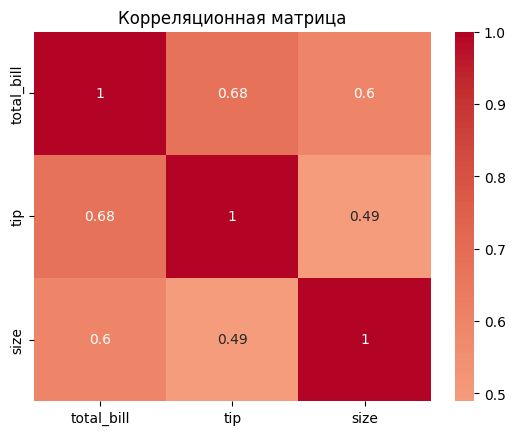

In [5]:
num_cols = ['total_bill','tip', 'size']
correlation_matrix = df[num_cols].corr()

# Визуализация тепловой карты
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица')
plt.show()

In [6]:
# сразу обозначаем признаки, которые мы используем
df['sex'] = df['sex'].astype('category')
df['smoker'] = df['smoker'].astype('category')
df['day'] = df['day'].astype('category')
df['time'] = df['time'].astype('category')  # целевая

### EDA

In [19]:
# Создаем бинарную переменную
df['tip_level'] = df['tip'].apply(
    lambda x: 'high' if x > df['tip'].median() else 'low'
)
df.tip_level

,tip_level
0,low
1,low
2,high
3,high
4,high
...,...
239,high
240,low
241,low
242,low


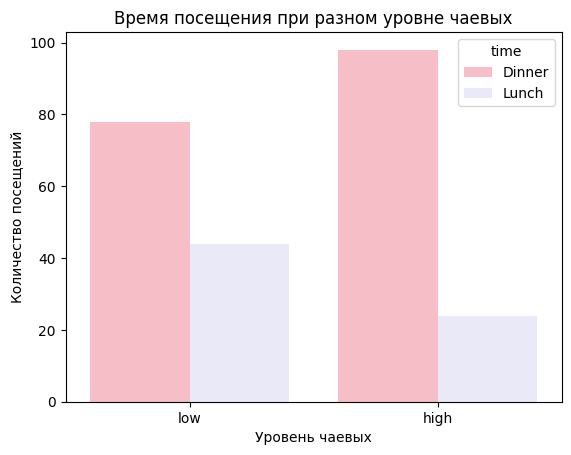

In [18]:
# Визуализируем что получилось
sns.countplot(data=df, x='tip_level', hue='time', palette=['lightpink', 'lavender'])
plt.title('Время посещения при разном уровне чаевых')
plt.xlabel('Уровень чаевых')
plt.ylabel('Количество посещений')
plt.show()

Для высоких чаевых (high):

Намного больше посещений во время ужина

Обед составляет небольшую долю высоких чаевых

Для низких чаевых (low):

Также доминируют ужины

Доля обедов относительно выше по сравнению с высокими чаевыми

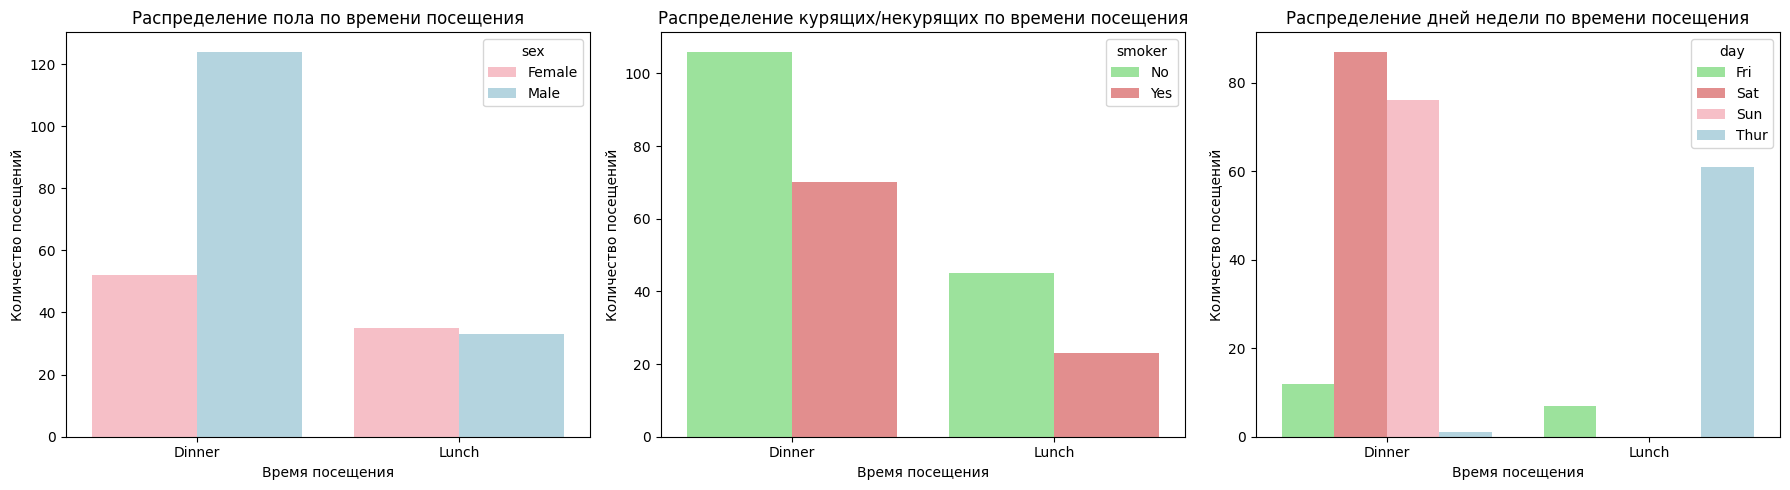

СВОДКА РАСПРЕДЕЛЕНИЯ ПО ВРЕМЕНИ ПОСЕЩЕНИЯ
     ВРЕМЯ      |         ПОЛ          |       КУРЕНИЕ        |                  ДНИ НЕДЕЛИ                  
----------------------------------------------------------------------------------------------------
Dinner          | male:124 female:52   | yes:70 no:106        | Thu:1 Fri:12 Sat:87 Sun:76                   
Lunch           | male:33 female:35    | yes:23 no:45         | Thu:61 Fri:7 Sat:0 Sun:0                     


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Время и пол
sns.countplot(data=df, x='time', hue='sex', palette=['lightpink', 'lightblue'], ax=axes[0])
axes[0].set_title('Распределение пола по времени посещения')
axes[0].set_xlabel('Время посещения')
axes[0].set_ylabel('Количество посещений')

# 2. Время и курение
sns.countplot(data=df, x='time', hue='smoker', palette=['lightgreen', 'lightcoral'], ax=axes[1])
axes[1].set_title('Распределение курящих/некурящих по времени посещения')
axes[1].set_xlabel('Время посещения')
axes[1].set_ylabel('Количество посещений')

# 3. Время и дни недели
sns.countplot(data=df, x='time', hue='day', palette=['lightgreen', 'lightcoral', 'lightpink', 'lightblue'],ax=axes[2])
axes[2].set_title('Распределение дней недели по времени посещения')
axes[2].set_xlabel('Время посещения')
axes[2].set_ylabel('Количество посещений')

plt.tight_layout()
plt.show()

print("СВОДКА РАСПРЕДЕЛЕНИЯ ПО ВРЕМЕНИ ПОСЕЩЕНИЯ")
print("=" * 100)

sex_crosstab = pd.crosstab(df['time'], df['sex'])
smoker_crosstab = pd.crosstab(df['time'], df['smoker'])
day_crosstab = pd.crosstab(df['time'], df['day'])


# Фиксированная ширина для каждой колонки
TIME_WIDTH = 15
SEX_WIDTH = 20
SMOKER_WIDTH = 20
DAY_WIDTH = 45

time_lines = [f"{idx}"[:TIME_WIDTH].ljust(TIME_WIDTH) for idx in sex_crosstab.index]

# Пол (упрощенный)
sex_lines = []
for time_val in sex_crosstab.index:
    male = sex_crosstab.loc[time_val, 'Male']
    female = sex_crosstab.loc[time_val, 'Female']
    sex_lines.append(f"male:{male} female:{female}"[:SEX_WIDTH].ljust(SEX_WIDTH))

# Курение (упрощенный)
smoker_lines = []
for time_val in smoker_crosstab.index:
    yes = smoker_crosstab.loc[time_val, 'Yes']
    no = smoker_crosstab.loc[time_val, 'No']
    smoker_lines.append(f"yes:{yes} no:{no}"[:SMOKER_WIDTH].ljust(SMOKER_WIDTH))

# Дни недели - все дни гарантированно
day_lines = []
for time_val in day_crosstab.index:
    days_counts = []
    for day in ['Thur', 'Fri', 'Sat', 'Sun']:
        count = day_crosstab.loc[time_val, day] if day in day_crosstab.columns else 0
        days_counts.append(f"{day[:3]}:{count}")
    day_lines.append(" ".join(days_counts)[:DAY_WIDTH].ljust(DAY_WIDTH))

max_len = len(time_lines)

print(f"{'ВРЕМЯ':^{TIME_WIDTH}} | {'ПОЛ':^{SEX_WIDTH}} | {'КУРЕНИЕ':^{SMOKER_WIDTH}} | {'ДНИ НЕДЕЛИ':^{DAY_WIDTH}}")
print("-" * 100)

for i in range(max_len):
    t = time_lines[i]
    s = sex_lines[i]
    sm = smoker_lines[i]
    d = day_lines[i]

    print(f"{t} | {s} | {sm} | {d}")

МИНИ-ВЫВОД:

Время посещения: Ужин (Dinner) значительно популярнее обеда (Lunch) - 176 vs 68 посещений

Гендерное распределение:

Ужин: сильный перекос в сторону мужчин (124 vs 52)

Обед: почти равное распределение (33 vs 35)

Курение:

В обеденное время курящих меньше (23 vs 45)

Вечером разница менее выражена (70 vs 106)

Дни недели:

Обеды - почти исключительно четверги (61 из 68)

Ужины - преимущественно выходные (87 суббот + 76 воскресений)

Пятница - переходный день с ужинами

In [10]:
# Создаем таблицу для анализа взаимосвязи между переменными tip_level и time
table = pd.crosstab(df['tip_level'], df['time'])
table

time,Dinner,Lunch
tip_level,,
high,98,24
low,78,44


In [11]:
# Проверяем  статистическую значимость связи между tip_level и time
chi2, p, dof, expected = chi2_contingency(table)
print(f"χ² = {chi2:.3f}")
print(f"p-value = {p}")


χ² = 7.360
p-value = 0.006669227930322343


p < 0.05 → зависимость есть (значимая)

p ≥ 0.05 → зависимость не доказана

Из этого следует что время посещения влиет на уровень чаевых

In [12]:
best_features = ['total_bill', 'tip', 'size', 'day', 'time']

### Нормализация данных

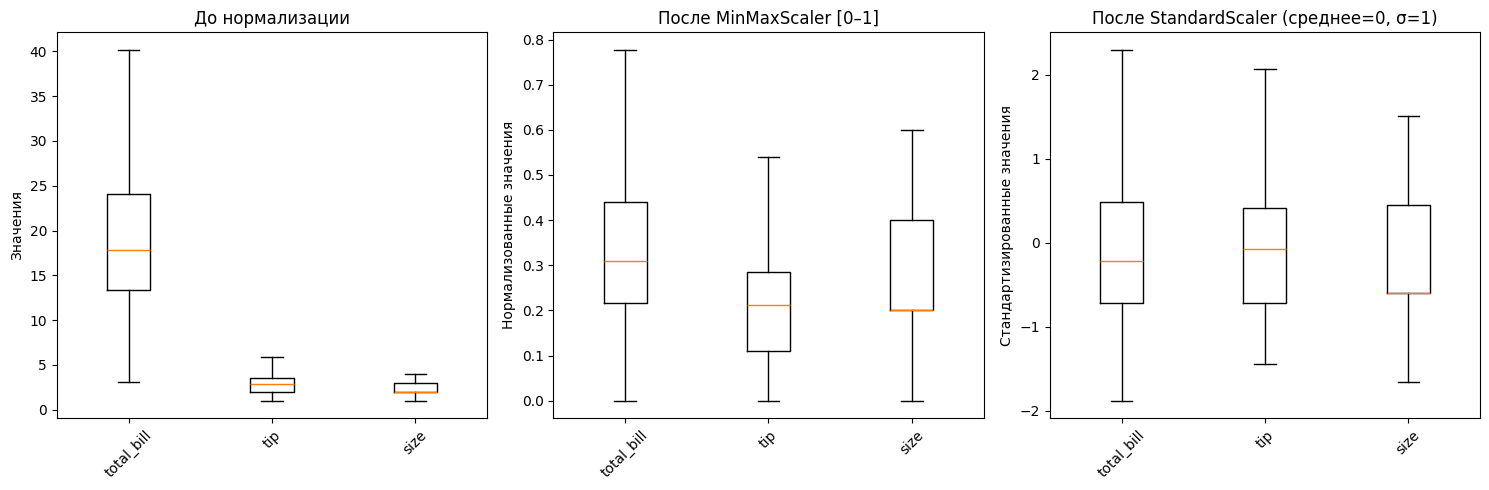


СРАВНЕНИЕ ДИАПАЗОНОВ ПРИЗНАКОВ
 СТАТИСТИКА  |          ДО НОРМАЛИЗАЦИИ          |           MINMAX SCALER [0-1]           |             STANDARD SCALER             
---------------------------------------------------------------------------------------------------------------------------------------
Минимум      | total_bill:3.1 tip:1.0 size:1.0   | total_bill:0.000 tip:0.000 size:0.000   | total_bill:-1.882 tip:-1.447 size:-1.654 |
Максимум     | total_bill:50.8 tip:10.0 size:6.0 | total_bill:1.000 tip:1.000 size:1.000   | total_bill:3.492 tip:5.071 size:3.614    |
Среднее      | total_bill:19.8 tip:3.0 size:2.6  | total_bill:0.350 tip:0.222 size:0.314   | total_bill:-0.000 tip:0.000 size:-0.000  |
Стд. откл.   | total_bill:8.9 tip:1.4 size:1.0   | total_bill:0.186 tip:0.154 size:0.190   | total_bill:1.002 tip:1.002 size:1.002    |




Результаты One-Hot Encoding:
Исходные категориальные признаки: ['day', 'time']
После кодирования: ['day_Sat', 'day_Sun', 'day_Thur', 'time_Lunch']

Ра

In [13]:
# Выбираем признаки для обработки
numeric_features = ['total_bill', 'tip', 'size']
categorical_features = ['day', 'time']

# Берем числовые признаки
num_df = df[['total_bill', 'tip', 'size']].copy()

# Применяем два метода нормализации
minmax_scaled = pd.DataFrame(MinMaxScaler().fit_transform(num_df), columns=num_df.columns)
std_scaled = pd.DataFrame(StandardScaler().fit_transform(num_df), columns=num_df.columns)

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Исходные данные
axes[0].boxplot(num_df.values, showfliers=False)
axes[0].set_title("До нормализации")
axes[0].set_xticks(range(1, len(num_df.columns)+1))
axes[0].set_xticklabels(num_df.columns, rotation=45)
axes[0].set_ylabel("Значения")

# После MinMaxScaler
axes[1].boxplot(minmax_scaled.values, showfliers=False)
axes[1].set_title("После MinMaxScaler [0–1]")
axes[1].set_xticks(range(1, len(num_df.columns)+1))
axes[1].set_xticklabels(num_df.columns, rotation=45)
axes[1].set_ylabel("Нормализованные значения")

# После StandardScaler
axes[2].boxplot(std_scaled.values, showfliers=False)
axes[2].set_title("После StandardScaler (среднее=0, σ=1)")
axes[2].set_xticks(range(1, len(num_df.columns)+1))
axes[2].set_xticklabels(num_df.columns, rotation=45)
axes[2].set_ylabel("Стандартизированные значения")

plt.tight_layout()
plt.show()

# Сравнительная таблица
print("\nСРАВНЕНИЕ ДИАПАЗОНОВ ПРИЗНАКОВ")
print("=" * 135)

# Фиксированная ширина для колонок
STAT_WIDTH = 12
ORIGINAL_WIDTH = 33
MINMAX_WIDTH = 39
STANDARD_WIDTH = 40

# Заголовки
print(f"{'СТАТИСТИКА':^{STAT_WIDTH}} | {'ДО НОРМАЛИЗАЦИИ':^{ORIGINAL_WIDTH}} | {'MINMAX SCALER [0-1]':^{MINMAX_WIDTH}} | {'STANDARD SCALER':^{STANDARD_WIDTH}}")
print("-" * 135)

# Данные для таблицы
stats = ['min', 'max', 'mean', 'std']
original_data = num_df.describe().loc[stats]
minmax_data = minmax_scaled.describe().loc[stats]
standard_data = std_scaled.describe().loc[stats]

for stat in stats:
    # Форматируем строки для каждого метода
    orig_line = f"total_bill:{original_data.loc[stat, 'total_bill']:.1f} tip:{original_data.loc[stat, 'tip']:.1f} size:{original_data.loc[stat, 'size']:.1f}"[:ORIGINAL_WIDTH].ljust(ORIGINAL_WIDTH)

    minmax_line = f"total_bill:{minmax_data.loc[stat, 'total_bill']:.3f} tip:{minmax_data.loc[stat, 'tip']:.3f} size:{minmax_data.loc[stat, 'size']:.3f}"[:MINMAX_WIDTH].ljust(MINMAX_WIDTH)

    standard_line = f"total_bill:{standard_data.loc[stat, 'total_bill']:.3f} tip:{standard_data.loc[stat, 'tip']:.3f} size:{standard_data.loc[stat, 'size']:.3f}"[:STANDARD_WIDTH].ljust(STANDARD_WIDTH)

    # Русские названия статистик
    stat_names = {'min': 'Минимум', 'max': 'Максимум', 'mean': 'Среднее', 'std': 'Стд. откл.'}
    stat_name = stat_names[stat].ljust(STAT_WIDTH)

    print(f"{stat_name} | {orig_line} | {minmax_line} | {standard_line} |")

print()
print()
print()
print()

# Применяем OneHotEncoding
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)
cat_encoded = onehot_encoder.fit_transform(df[categorical_features])

# Создаем DataFrame с закодированными признаками
cat_encoded_df = pd.DataFrame(
    cat_encoded,
    columns=onehot_encoder.get_feature_names_out(categorical_features)
)

print("Результаты One-Hot Encoding:")
print(f"Исходные категориальные признаки: {categorical_features}")
print(f"После кодирования: {list(cat_encoded_df.columns)}")

print("\nРаспределение значений в закодированных признаках:")
for col in cat_encoded_df.columns:
    print(f"{col}: {cat_encoded_df[col].sum()} единиц")

# Создаем полный препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),      # Нормализация числовых
        ('cat', OneHotEncoder(drop='first'), categorical_features)  # One-hot категориальных
    ]
)

# Применяем преобразования ко всем данным
X_processed = preprocessor.fit_transform(df[best_features])

# Получаем имена признаков после преобразования
feature_names = (numeric_features +
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))

processed_df = pd.DataFrame(X_processed, columns=feature_names)




### Нормализация числовых признаков:

**StandardScaler:**
- Средние значения приближены к нулю (-0.000, 0.000, -0.000) - достигнуто центрирование данных
- Стандартные отклонения равны 1.002 - признаки приведены к единому масштабу

**MinMaxScaler:**
- Все значения приведены к диапазону [0, 1]
- Сохранены относительные пропорции исходных распределений

## One-Hot Encoding категориальных признаков:

**Распределение по дням недели:**
- Суббота (Sat): 87 посещений - наиболее популярный день
- Воскресенье (Sun): 76 посещений - второй по популярности
- Четверг (Thur): 62 посещения - наименее популярный из представленных дней

**Распределение по времени посещения:**
- Обед (Lunch): 68 посещений
- Ужин (Dinner) является базовой категорией

Данные полностью подготовлены для обучения модели логистической регрессии.

### Model

Данные подготовлены для обучения модели
X_train_processed: (170, 8)
X_test_processed: (74, 8)
Целевая переменная: time (Dinner=1, Lunch=0)
Баланс классов: {1: 0.7213114754098361, 0: 0.2786885245901639}

МЕТРИКИ КАЧЕСТВА МОДЕЛИ
Accuracy: 0.9595

Отчет классификации:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        21
           1       1.00      0.94      0.97        53

    accuracy                           0.96        74
   macro avg       0.94      0.97      0.95        74
weighted avg       0.96      0.96      0.96        74



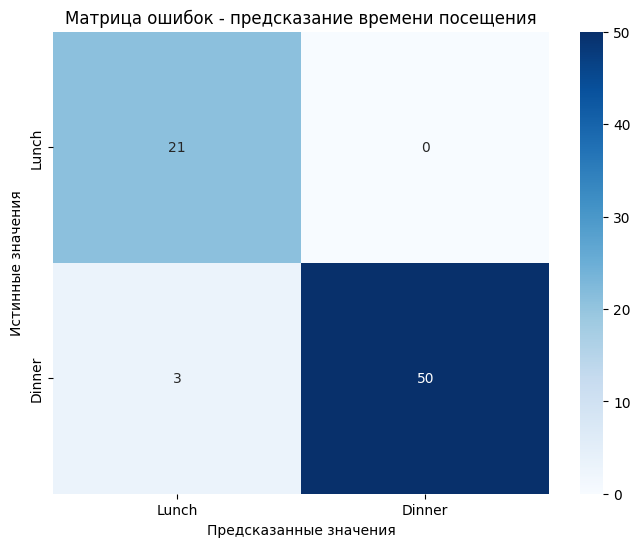


КОЭФФИЦИЕНТЫ МОДЕЛИ
total_bill          :   3.2705
tip                 :  -2.0334
size                :  -1.6759
day_Sat             :  11.8251
day_Sun             :  15.1487
day_Thur            :  -5.9876
sex_Male            :  -0.9542
smoker_Yes          :  -1.9972
Свободный член (intercept): 2.0151


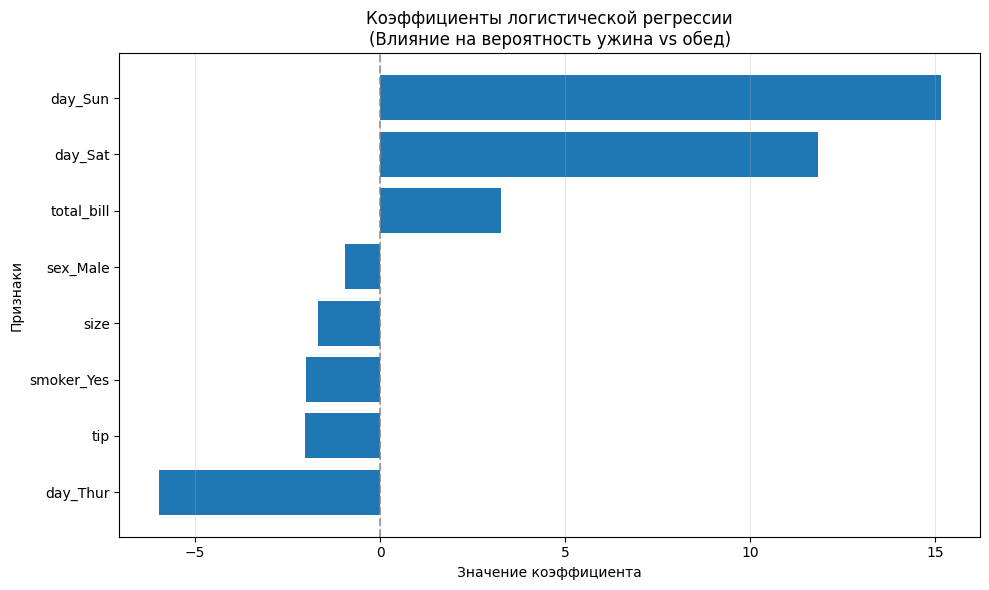

Влияние признаков на вероятность посещения в УЖИН (Dinner):
------------------------------------------------------------
total_bill           УВЕЛИЧИВАЕТ вероятность ужина (коэф: 3.2705)
tip                  УМЕНЬШАЕТ вероятность ужина (увеличивает вероятность обеда) (коэф: -2.0334)
size                 УМЕНЬШАЕТ вероятность ужина (увеличивает вероятность обеда) (коэф: -1.6759)
day_Sat              УВЕЛИЧИВАЕТ вероятность ужина (коэф: 11.8251)
day_Sun              УВЕЛИЧИВАЕТ вероятность ужина (коэф: 15.1487)
day_Thur             УМЕНЬШАЕТ вероятность ужина (увеличивает вероятность обеда) (коэф: -5.9876)
sex_Male             УМЕНЬШАЕТ вероятность ужина (увеличивает вероятность обеда) (коэф: -0.9542)
smoker_Yes           УМЕНЬШАЕТ вероятность ужина (увеличивает вероятность обеда) (коэф: -1.9972)


In [22]:
# Целевая переменная - время посещения (Time)
# Преобразуем в бинарную: Dinner -> 1, Lunch -> 0
y = df['time'].map({'Dinner': 1, 'Lunch': 0}).astype(int)

# Признаки - выбираем на основе предыдущего анализа
best_features = ['total_bill', 'tip', 'size', 'day', 'sex', 'smoker']
X = df[best_features]

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Препроцессинг данных
numeric_features = ['total_bill', 'tip', 'size']
categorical_features = ['day', 'sex', 'smoker']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Применяем препроцессинг
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Получаем имена признаков
feature_names = (numeric_features +
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))

print("Данные подготовлены для обучения модели")
print(f"X_train_processed: {X_train_processed.shape}")
print(f"X_test_processed: {X_test_processed.shape}")
print(f"Целевая переменная: time (Dinner=1, Lunch=0)")
print(f"Баланс классов: {y.value_counts(normalize=True).to_dict()}")

# ОБУЧЕНИЕ МОДЕЛИ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ

# Создание и обучение модели
model = LogisticRegression(
    penalty=None,  # без регуляризации
    random_state=42,
    max_iter=1000
)

model.fit(X_train_processed, y_train)

# Предсказания на тестовых данных
y_pred = model.predict(X_test_processed)
y_pred_proba = model.predict_proba(X_test_processed)

# Вывод метрик качества
print("\n" + "="*50)
print("МЕТРИКИ КАЧЕСТВА МОДЕЛИ")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

print("\nОтчет классификации:")
print(classification_report(y_test, y_pred))

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Lunch', 'Dinner'],
            yticklabels=['Lunch', 'Dinner'])
plt.title('Матрица ошибок - предсказание времени посещения')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.show()

# Вывод коэффициентов модели
print("\n" + "="*50)
print("КОЭФФИЦИЕНТЫ МОДЕЛИ")
print("="*50)
coefficients = model.coef_[0]

for feature, coef in zip(feature_names, coefficients):
    print(f"{feature:20}: {coef:8.4f}")

print(f"Свободный член (intercept): {model.intercept_[0]:.4f}")

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values('coefficient', ascending=True)

plt.barh(feature_importance['feature'], feature_importance['coefficient'])
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
plt.title('Коэффициенты логистической регрессии\n(Влияние на вероятность ужина vs обед)')
plt.xlabel('Значение коэффициента')
plt.ylabel('Признаки')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Интерпретация результатов
print("Влияние признаков на вероятность посещения в УЖИН (Dinner):")
print("-" * 60)

for feature, coef in zip(feature_names, coefficients):
    if coef > 0:
        effect = "УВЕЛИЧИВАЕТ"
        interpretation = "вероятность ужина"
    else:
        effect = "УМЕНЬШАЕТ"
        interpretation = "вероятность ужина (увеличивает вероятность обеда)"

    print(f"{feature:20} {effect} {interpretation} (коэф: {coef:.4f})")

### **Общее качество:**
- **Accuracy: 95.95%** - отличный результат
- Модель значительно превосходит базовый прогноз (72% - доля ужинов)

### **Сбалансированность предсказаний:**
- **Обеды (Lunch):** precision 88%, recall 100%
- **Ужины (Dinner):** precision 100%, recall 94%
- Модель одинаково эффективна для обоих классов

### **Влияние признаков на вероятность ужина:**

**Сильно увеличивают:**
- **day_Sun (+15.15)** - самый сильный предиктор
- **day_Sat (+11.83)**
- **total_bill (+3.27)** - большие счета ассоциированы с ужинами

**Уменьшают (увеличивают вероятность обеда):**
- **day_Thur (-5.99)** - четверг связан с обедами
- **tip (-2.03)** - большие чаевые чаще при обедах
- **smoker_Yes (-2.00)** - курящие чаще обедают
- **size (-1.68)** - большие компании предпочитают обеды

**Слабое влияние:**
- **sex_Male (-0.95)** - незначительный фактор

### **Вывод:**
Модель демонстрирует высокое качество предсказаний. День недели - ключевой фактор определения времени посещения.